In [1]:
# set work dir
import os
os.chdir("../")

In [2]:
import time
import spo
import torch
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
torch.manual_seed(135)

Auto-Sklearn cannot be imported.


## Init Data

In [3]:
# generate data for grid network (features and costs)
m = 48 # number of items
n = 1000 # number of data
p = 5 # size of feature
deg = 4 # polynomial degree
dim = 3 # dimension of knapsack
weights, x, c = spo.data.knapsack.genData(n+1000, p, m, deg=deg, dim=dim)

In [4]:
weights

array([[4.59, 4.87, 5.19, 7.59, 6.8 , 4.97, 4.84, 3.22, 7.9 , 3.62, 3.12,
        6.81, 7.09, 3.23, 4.47, 5.23, 6.11, 5.23, 4.27, 6.66, 5.21, 3.72,
        7.83, 5.64, 7.56, 3.28, 4.31, 3.85, 6.43, 4.26, 7.56, 6.4 , 6.09,
        6.4 , 4.5 , 6.31, 6.35, 3.07, 6.03, 7.39, 3.48, 5.57, 6.27, 4.55,
        5.64, 5.66, 3.27, 6.68],
       [4.2 , 5.61, 6.13, 7.88, 4.61, 4.92, 6.09, 7.95, 7.11, 4.02, 3.07,
        7.84, 6.29, 5.78, 5.57, 5.65, 7.41, 5.21, 3.42, 6.48, 5.77, 7.67,
        7.32, 3.31, 4.36, 4.75, 3.38, 3.44, 6.3 , 4.85, 7.09, 5.7 , 4.05,
        6.04, 6.51, 3.41, 7.94, 6.05, 7.18, 3.64, 4.35, 4.45, 4.27, 4.87,
        5.74, 3.16, 5.41, 3.81],
       [3.51, 5.98, 5.79, 6.62, 5.11, 3.16, 7.01, 6.48, 6.36, 4.12, 7.9 ,
        7.69, 3.68, 4.73, 5.85, 5.03, 3.69, 7.13, 7.11, 5.72, 5.8 , 4.59,
        6.85, 4.14, 6.18, 4.28, 5.38, 5.79, 6.78, 3.79, 4.61, 3.06, 7.78,
        3.94, 6.06, 7.22, 5.18, 3.44, 3.93, 5.56, 3.56, 6.59, 5.  , 5.24,
        7.94, 6.75, 6.37, 7.64]])

In [5]:
# convert max into min
c = - c

## Optimization Model 

In [6]:
# capacity
cap = [30, 30, 30]

In [7]:
#ks_model = spo.model.omo.knapsackModel(weights, cap, solver='gurobi')
ks_model = spo.model.omo.knapsackModel(weights, cap, solver='glpk')

Solver in the background: glpk


In [8]:
# solve
ks_model.setObj([-i for i in range(m)])
sol, obj = ks_model.solve()
print(sol)
print('Obj: {}'.format(obj))
for i in ks_model.items:
    if sol[i] > 1e-3:
        print(i)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0]
Obj: -247.0
37
39
40
42
43
46


In [9]:
# relax
ks_model_rel = ks_model.relax()

Solver in the background: glpk


In [10]:
# solve
ks_model_rel.setObj([-i for i in range(m)])
sol, obj = ks_model_rel.solve()
print(sol)
print('Obj: {}'.format(obj))
for i in ks_model_rel.items:
    if sol[i] > 1e-3:
        print(i)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.734152948395629, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0748391080238295, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.525492392040327, 0.0]
Obj: -256.8501166470489
31
37
39
40
42
43
45
46


## Data Loader 

In [11]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

In [12]:
# data split
x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000, random_state=246)

In [13]:
# get training data set
ks_dataset_train = spo.data.dataset.optDataset(ks_model, x_train, c_train)

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:46<00:00, 21.65it/s]


In [14]:
# get training data set for relaxation
ks_dataset_train_rel = spo.data.dataset.optDataset(ks_model_rel, x_train, c_train)

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:45<00:00, 22.01it/s]


In [15]:
# get test data set
ks_dataset_test = spo.data.dataset.optDataset(ks_model, x_test, c_test)

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:45<00:00, 21.76it/s]


In [16]:
# get data loader
batch_size = 32
ks_loader_train = DataLoader(ks_dataset_train, batch_size=batch_size, shuffle=True)
ks_loader_train_rel = DataLoader(ks_dataset_train_rel, batch_size=batch_size, shuffle=True)
ks_loader_test = DataLoader(ks_dataset_test, batch_size=batch_size, shuffle=False)

In [17]:
for i, data in enumerate(ks_loader_train):
    x, c, w, z = data
    break

In [18]:
x.shape

torch.Size([32, 5])

In [19]:
c.shape

torch.Size([32, 48])

In [20]:
w.shape

torch.Size([32, 48])

In [21]:
z.shape

torch.Size([32, 1])

## Linear Regression from Scikit-Lear 

In [22]:
from sklearn.linear_model import LinearRegression

In [23]:
# prediction model
reg = LinearRegression()

## Two-Stage 

In [24]:
# build model
twostage_model = spo.twostage.sklearnPred(reg)

In [25]:
# training
twostage_model.fit(ks_dataset_train.feats, ks_dataset_train.costs)

MultiOutputRegressor(estimator=LinearRegression())

In [26]:
# prediction
c_test_pred = twostage_model.predict(ks_dataset_test.feats)

In [27]:
# evaluate
truespo = 0
unambspo = 0
for i in tqdm(range(1000)):
    c_pred_i = c_test_pred[i]
    c_true_i = ks_dataset_test.costs[i]
    z_true_i = ks_dataset_test.objs[i,0]
    truespo += spo.eval.calTrueSPO(ks_model, c_pred_i, c_true_i, z_true_i)
    unambspo += spo.eval.calUnambSPO(ks_model, c_pred_i, c_true_i, z_true_i)
time.sleep(1)
print('Normalized true SPO Loss: {:.2f}%'.format(truespo / abs(ks_dataset_test.objs.sum()) * 100))
print('Normalized unambiguous SPO Loss: {:.2f}%'.format(unambspo / abs(ks_dataset_test.objs.sum()) * 100))

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:39<00:00,  6.29it/s]


Normalized true SPO Loss: 2.48%
Normalized unambiguous SPO Loss: 2.48%


In [28]:
# compare solutions
for i, data in enumerate(ks_loader_test):
    # load data
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # convert to numpy
    x = x.to('cpu').detach().numpy()
    c = c.to('cpu').detach().numpy()
    w = w.to('cpu').detach().numpy()
    z = z.to('cpu').detach().numpy()
    # predict
    cp = twostage_model.predict(x)
    for j in range(min(10, batch_size)):
        print('Sample {}:'.format(j))
        print('    True cost:', ', '.join(['{:.2f}'.format(-cost) for cost in c[j]]))
        print('    Pred cost:', ', '.join(['{:.2f}'.format(-cost) for cost in cp[j]]))
        # solve cost from prediction
        ks_model.setObj(cp[j])
        wpj, _ = ks_model.solve()
        zpj = np.dot(c[j], wpj)
        print('    True sol: ' + ', '.join(['{:.0f}'.format(x) for x in w[j]]) + ', True obj: {:.2f}'.format(-z[j,0]))
        print('    Pred sol: '+  ', '.join(['{:.0f}'.format(x) for x in wpj]) + ', Pred obj: {:.2f}'.format(-zpj))
        print()
    break

Sample 0:
    True cost: 5.00, 4.00, 5.00, 5.00, 4.00, 3.00, 5.00, 5.00, 3.00, 3.00, 4.00, 4.00, 4.00, 4.00, 4.00, 5.00, 5.00, 5.00, 5.00, 3.00, 4.00, 4.00, 4.00, 5.00, 5.00, 5.00, 4.00, 3.00, 5.00, 3.00, 3.00, 5.00, 3.00, 3.00, 5.00, 5.00, 3.00, 5.00, 3.00, 4.00, 5.00, 3.00, 5.00, 3.00, 4.00, 5.00, 3.00, 4.00
    Pred cost: 6.95, 5.45, 4.83, 6.22, 6.27, 3.66, 4.83, 6.28, 3.07, 3.79, 5.49, 5.48, 5.48, 4.37, 4.40, 5.50, 6.92, 5.50, 6.19, 3.00, 4.40, 5.49, 4.40, 5.50, 4.83, 6.14, 6.27, 3.67, 6.92, 4.34, 4.25, 6.92, 3.79, 3.80, 6.92, 4.83, 3.66, 5.50, 4.25, 4.40, 5.50, 3.07, 6.12, 3.67, 6.27, 6.92, 3.67, 5.48
    True sol: 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, True obj: 33.00
    Pred sol: 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, Pred obj: 33.00

Sample 1:
    True cost: 1.00, 5.00, 

    True sol: 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, True obj: 85.00
    Pred sol: 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, Pred obj: 76.00

Sample 9:
    True cost: 3.00, 7.00, 4.00, 2.00, 11.00, 8.00, 4.00, 4.00, 9.00, 4.00, 9.00, 12.00, 12.00, 2.00, 3.00, 3.00, 8.00, 3.00, 3.00, 3.00, 3.00, 9.00, 3.00, 3.00, 4.00, 6.00, 11.00, 10.00, 8.00, 9.00, 7.00, 8.00, 4.00, 3.00, 8.00, 4.00, 8.00, 3.00, 7.00, 3.00, 3.00, 9.00, 9.00, 6.00, 11.00, 8.00, 6.00, 12.00
    Pred cost: 4.37, 7.58, 4.27, 3.05, 10.74, 7.41, 4.27, 5.82, 7.14, 4.39, 8.84, 10.24, 10.24, 1.98, 3.23, 4.29, 9.34, 4.29, 4.38, 3.00, 3.23, 8.84, 3.23, 3.23, 4.27, 7.70, 10.74, 8.61, 9.34, 8.99, 7.43, 9.34, 4.39, 3.16, 9.34, 4.27, 7.41, 4.29, 7.43, 3.23, 3.23, 7.14, 9.04, 6.24, 10.74, 9.34, 6.24, 10.24
    True sol: 0, 0, 0, 0

## Linear Regression from PyTorch

In [29]:
from torch import nn

In [30]:
# build linear model
class LinearRegression(nn.Module):
    
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(p, m)
    
    def forward(self, x):
        out = self.linear(x)
        return out

## SPO+ 

In [31]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [32]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=5e-3)

In [33]:
# init SPO+ loss
criterion = spo.func.SPOPlus(ks_model, processes=4)

Num of cores: 4


In [34]:
# train model
num_epochs = 300
reg.train()
loss_log = []
loss_log_truespo = []
loss_log_unambspo = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(ks_loader_train):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # forward pass
        cp = reg(x)
        loss = criterion.apply(cp, c, w, z).mean()
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_log.append(loss.item())
    if (epoch + 1) % 10 == 0:
        # true SPO
        trueloss = spo.eval.trueSPO(reg, ks_model, ks_loader_test)
        loss_log_truespo.append(trueloss)
        # unambiguous SPO 
        unambloss = spo.eval.unambSPO(reg, ks_model, ks_loader_test)
        loss_log_unambspo.append(unambloss)
        print('Epoch {:3}, Loss: {:8.4f}, True SPO Loss: {:7.4f}%, Unambiguous SPO Loss: {:7.4f}%'. \
              format(epoch+1, loss.item(), trueloss*100, unambloss*100))

Epoch  10, Loss:  18.2505, True SPO Loss: 16.2195%, Unambiguous SPO Loss: 16.2195%
Epoch  20, Loss:  18.0076, True SPO Loss:  4.3701%, Unambiguous SPO Loss:  4.3701%
Epoch  30, Loss:   3.6208, True SPO Loss:  1.6132%, Unambiguous SPO Loss:  1.6155%
Epoch  40, Loss:   4.7755, True SPO Loss:  0.9942%, Unambiguous SPO Loss:  0.9942%
Epoch  50, Loss:  18.3706, True SPO Loss:  0.8124%, Unambiguous SPO Loss:  0.8124%
Epoch  60, Loss:  14.5297, True SPO Loss:  0.6421%, Unambiguous SPO Loss:  0.6421%
Epoch  70, Loss:   2.0622, True SPO Loss:  0.5362%, Unambiguous SPO Loss:  0.5362%
Epoch  80, Loss:   2.1888, True SPO Loss:  0.4948%, Unambiguous SPO Loss:  0.4948%
Epoch  90, Loss:  10.4885, True SPO Loss:  0.5707%, Unambiguous SPO Loss:  0.5707%
Epoch 100, Loss:   1.6274, True SPO Loss:  0.4718%, Unambiguous SPO Loss:  0.4718%
Epoch 110, Loss:   2.1394, True SPO Loss:  0.5201%, Unambiguous SPO Loss:  0.5201%
Epoch 120, Loss:   1.4658, True SPO Loss:  0.5109%, Unambiguous SPO Loss:  0.5109%
Epoc

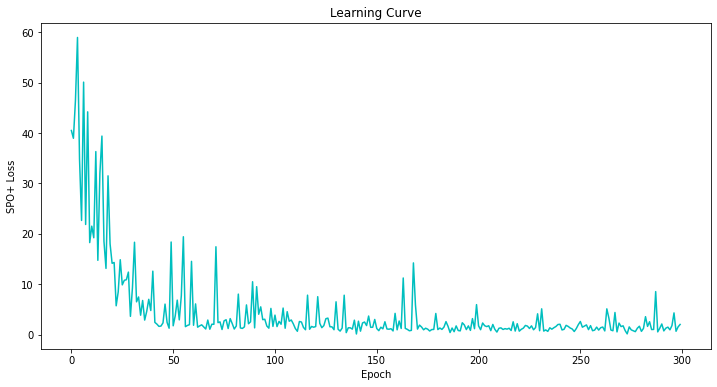

In [35]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(loss_log, color='c')
plt.xlabel('Epoch')
plt.ylabel('SPO+ Loss')
plt.title('Learning Curve')
plt.show()

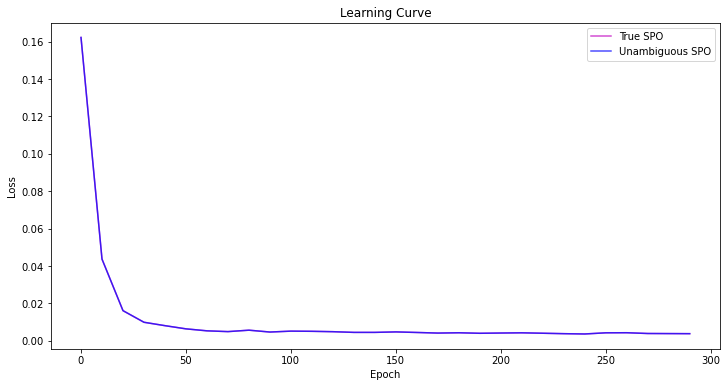

In [36]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(range(0, num_epochs, 10), loss_log_truespo, color='m', alpha=0.7, label='True SPO')
plt.plot(range(0, num_epochs, 10), loss_log_unambspo, color='b', alpha=0.7, label='Unambiguous SPO')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [37]:
# evaluate
spoloss = spo.eval.trueSPO(reg, ks_model, ks_loader_test)
print('Normalized true SPO Loss: {:.2f}%'.format(spoloss * 100))
spoloss = spo.eval.unambSPO(reg, ks_model, ks_loader_test)
print('Normalized unambiguous SPO Loss: {:.2f}%'.format(spoloss * 100))

Normalized true SPO Loss: 0.38%
Normalized unambiguous SPO Loss: 0.38%


In [38]:
reg.eval()
# compare solutions
for i, data in enumerate(ks_loader_test):
    # load data
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = reg(x)
    # convert to numpy
    x = x.to('cpu').detach().numpy()
    c = c.to('cpu').detach().numpy()
    w = w.to('cpu').detach().numpy()
    z = z.to('cpu').detach().numpy()
    cp = cp.to('cpu').detach().numpy()
    for j in range(min(10, batch_size)):
        print('Sample {}:'.format(j))
        print('    True cost:', ', '.join(['{:.2f}'.format(-cost) for cost in c[j]]))
        print('    Pred cost:', ', '.join(['{:.2f}'.format(-cost) for cost in cp[j]]))
        # solve cost from prediction
        ks_model.setObj(cp[j])
        wpj, _ = ks_model.solve()
        zpj = np.dot(c[j], wpj)
        print('    True sol: ' + ', '.join(['{:.0f}'.format(x) for x in w[j]]) + ', True obj: {:.2f}'.format(-z[j,0]))
        print('    Pred sol: '+  ', '.join(['{:.0f}'.format(x) for x in wpj]) + ', Pred obj: {:.2f}'.format(-zpj))
        print()
    break

Sample 0:
    True cost: 5.00, 4.00, 5.00, 5.00, 4.00, 3.00, 5.00, 5.00, 3.00, 3.00, 4.00, 4.00, 4.00, 4.00, 4.00, 5.00, 5.00, 5.00, 5.00, 3.00, 4.00, 4.00, 4.00, 5.00, 5.00, 5.00, 4.00, 3.00, 5.00, 3.00, 3.00, 5.00, 3.00, 3.00, 5.00, 5.00, 3.00, 5.00, 3.00, 4.00, 5.00, 3.00, 5.00, 3.00, 4.00, 5.00, 3.00, 4.00
    Pred cost: 6.21, 4.52, 4.80, 5.56, 4.57, 2.39, 4.96, 5.32, 1.43, 3.46, 4.10, 3.74, 4.21, 3.51, 3.53, 5.09, 4.86, 4.94, 5.63, 1.73, 3.43, 4.04, 2.19, 5.49, 4.65, 4.78, 4.76, 2.74, 5.11, 2.82, 1.31, 5.01, 2.39, 2.77, 4.61, 4.88, 1.24, 5.55, 2.29, 3.27, 5.47, 1.71, 4.73, 2.02, 4.35, 4.69, 2.35, 3.36
    True sol: 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, True obj: 33.00
    Pred sol: 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, Pred obj: 33.00

Sample 1:
    True cost: 1.00, 5.00, 

    True sol: 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, True obj: 85.00
    Pred sol: 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, Pred obj: 84.00

Sample 9:
    True cost: 3.00, 7.00, 4.00, 2.00, 11.00, 8.00, 4.00, 4.00, 9.00, 4.00, 9.00, 12.00, 12.00, 2.00, 3.00, 3.00, 8.00, 3.00, 3.00, 3.00, 3.00, 9.00, 3.00, 3.00, 4.00, 6.00, 11.00, 10.00, 8.00, 9.00, 7.00, 8.00, 4.00, 3.00, 8.00, 4.00, 8.00, 3.00, 7.00, 3.00, 3.00, 9.00, 9.00, 6.00, 11.00, 8.00, 6.00, 12.00
    Pred cost: 0.37, 5.94, 2.02, -1.75, 9.36, 6.89, 2.86, 2.31, 7.95, 3.13, 7.65, 9.54, 10.21, -2.20, 0.02, 1.35, 6.27, 1.27, 1.37, -0.15, 0.08, 7.84, -2.99, 1.00, 2.45, 5.50, 9.43, 8.56, 4.40, 8.02, 5.49, 6.58, 1.71, -0.05, 6.77, 2.31, 5.96, 2.46, 6.52, -0.06, 1.93, 7.42, 7.73, 4.39, 9.22, 6.22, 5.03, 10.32
    True sol: 0, 0, 0,

## SPO+ Rel 

In [39]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [40]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=5e-3)

In [41]:
# init SPO+ loss
criterion = spo.func.SPOPlus(ks_model_rel, processes=4)

Num of cores: 4


In [42]:
# train model
num_epochs = 300
reg.train()
loss_log = []
loss_log_truespo = []
loss_log_unambspo = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(ks_loader_train_rel):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # forward pass
        cp = reg(x)
        loss = criterion.apply(cp, c, w, z).mean()
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_log.append(loss.item())
    if (epoch + 1) % 10 == 0:
        # true SPO
        trueloss = spo.eval.trueSPO(reg, ks_model, ks_loader_test)
        loss_log_truespo.append(trueloss)
        # unambiguous SPO 
        unambloss = spo.eval.unambSPO(reg, ks_model, ks_loader_test)
        loss_log_unambspo.append(unambloss)
        print('Epoch {:3}, Loss: {:8.4f}, True SPO Loss: {:7.4f}%, Unambiguous SPO Loss: {:7.4f}%'. \
              format(epoch+1, loss.item(), trueloss*100, unambloss*100))

Epoch  10, Loss:  25.9249, True SPO Loss: 11.4949%, Unambiguous SPO Loss: 11.4949%
Epoch  20, Loss:  13.6292, True SPO Loss:  2.9664%, Unambiguous SPO Loss:  2.9664%
Epoch  30, Loss:   7.1353, True SPO Loss:  1.3762%, Unambiguous SPO Loss:  1.3762%
Epoch  40, Loss:   6.4286, True SPO Loss:  0.8147%, Unambiguous SPO Loss:  0.8147%
Epoch  50, Loss:   6.4719, True SPO Loss:  0.6766%, Unambiguous SPO Loss:  0.6766%
Epoch  60, Loss:   8.2227, True SPO Loss:  0.6812%, Unambiguous SPO Loss:  0.6812%
Epoch  70, Loss:   2.6547, True SPO Loss:  0.5753%, Unambiguous SPO Loss:  0.5753%
Epoch  80, Loss:   4.9992, True SPO Loss:  0.5730%, Unambiguous SPO Loss:  0.5730%
Epoch  90, Loss:   0.7029, True SPO Loss:  0.4925%, Unambiguous SPO Loss:  0.4925%
Epoch 100, Loss:   1.0107, True SPO Loss:  0.5201%, Unambiguous SPO Loss:  0.5201%
Epoch 110, Loss:   2.0855, True SPO Loss:  0.5362%, Unambiguous SPO Loss:  0.5362%
Epoch 120, Loss:   1.0565, True SPO Loss:  0.4741%, Unambiguous SPO Loss:  0.4741%
Epoc

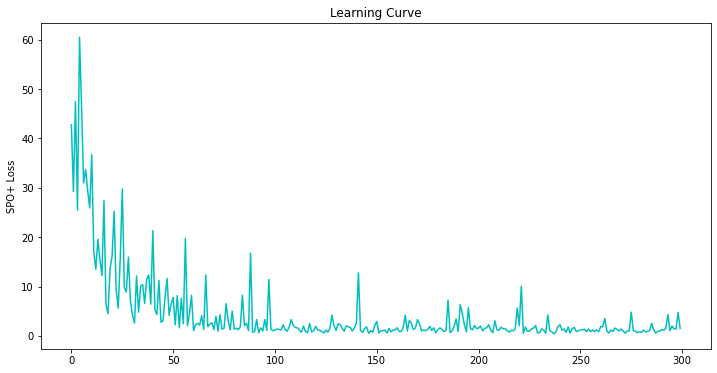

In [43]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(loss_log, color='c')
plt.ylabel('SPO+ Loss')
plt.title('Learning Curve')
plt.show()

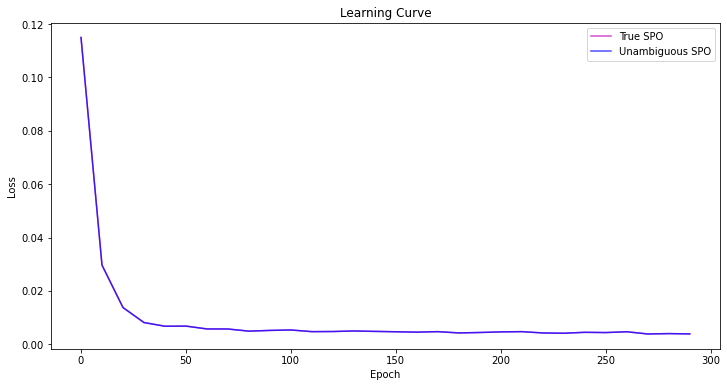

In [44]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(range(0, num_epochs, 10), loss_log_truespo, color='m', alpha=0.7, label='True SPO')
plt.plot(range(0, num_epochs, 10), loss_log_unambspo, color='b', alpha=0.7, label='Unambiguous SPO')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [45]:
# evaluate
spoloss = spo.eval.trueSPO(reg, ks_model, ks_loader_test)
print('Normalized true SPO Loss: {:.2f}%'.format(spoloss * 100))
spoloss = spo.eval.unambSPO(reg, ks_model, ks_loader_test)
print('Normalized unambiguous SPO Loss: {:.2f}%'.format(spoloss * 100))

Normalized true SPO Loss: 0.39%
Normalized unambiguous SPO Loss: 0.39%


In [46]:
reg.eval()
# compare solutions
for i, data in enumerate(ks_loader_test):
    # load data
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = reg(x)
    # convert to numpy
    x = x.to('cpu').detach().numpy()
    c = c.to('cpu').detach().numpy()
    w = w.to('cpu').detach().numpy()
    z = z.to('cpu').detach().numpy()
    cp = cp.to('cpu').detach().numpy()
    for j in range(min(10, batch_size)):
        print('Sample {}:'.format(j))
        print('    True cost:', ', '.join(['{:.2f}'.format(-cost) for cost in c[j]]))
        print('    Pred cost:', ', '.join(['{:.2f}'.format(-cost) for cost in cp[j]]))
        # solve cost from prediction
        ks_model.setObj(cp[j])
        wpj, _ = ks_model.solve()
        zpj = np.dot(c[j], wpj)
        print('    True sol: ' + ', '.join(['{:.0f}'.format(x) for x in w[j]]) + ', True obj: {:.2f}'.format(-z[j,0]))
        print('    Pred sol: '+  ', '.join(['{:.0f}'.format(x) for x in wpj]) + ', Pred obj: {:.2f}'.format(-zpj))
        print()
    break

Sample 0:
    True cost: 5.00, 4.00, 5.00, 5.00, 4.00, 3.00, 5.00, 5.00, 3.00, 3.00, 4.00, 4.00, 4.00, 4.00, 4.00, 5.00, 5.00, 5.00, 5.00, 3.00, 4.00, 4.00, 4.00, 5.00, 5.00, 5.00, 4.00, 3.00, 5.00, 3.00, 3.00, 5.00, 3.00, 3.00, 5.00, 5.00, 3.00, 5.00, 3.00, 4.00, 5.00, 3.00, 5.00, 3.00, 4.00, 5.00, 3.00, 4.00
    Pred cost: 6.54, 4.76, 5.31, 6.87, 4.77, 3.00, 5.89, 6.54, 2.19, 4.09, 5.26, 4.89, 5.26, 4.04, 4.17, 6.13, 4.84, 5.86, 6.33, 2.74, 4.12, 4.59, 4.13, 5.97, 5.53, 5.50, 5.32, 3.40, 5.99, 3.21, 2.19, 5.26, 3.65, 3.14, 4.98, 5.52, 2.35, 5.95, 2.59, 4.21, 5.91, 2.69, 5.12, 2.96, 4.29, 5.50, 3.08, 5.08
    True sol: 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, True obj: 33.00
    Pred sol: 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, Pred obj: 33.00

Sample 1:
    True cost: 1.00, 5.00, 

    True sol: 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, True obj: 85.00
    Pred sol: 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, Pred obj: 84.00

Sample 9:
    True cost: 3.00, 7.00, 4.00, 2.00, 11.00, 8.00, 4.00, 4.00, 9.00, 4.00, 9.00, 12.00, 12.00, 2.00, 3.00, 3.00, 8.00, 3.00, 3.00, 3.00, 3.00, 9.00, 3.00, 3.00, 4.00, 6.00, 11.00, 10.00, 8.00, 9.00, 7.00, 8.00, 4.00, 3.00, 8.00, 4.00, 8.00, 3.00, 7.00, 3.00, 3.00, 9.00, 9.00, 6.00, 11.00, 8.00, 6.00, 12.00
    Pred cost: 1.33, 6.72, 2.46, -0.26, 10.16, 6.96, 3.31, 3.53, 8.45, 3.61, 8.80, 11.07, 10.27, -1.03, 0.52, 2.65, 6.88, 2.62, 1.49, 1.16, 0.45, 8.68, 0.29, 1.78, 2.82, 6.21, 10.50, 9.31, 7.15, 8.51, 6.68, 7.26, 2.81, 0.24, 7.29, 3.54, 7.12, 2.73, 6.84, 0.47, 1.93, 8.01, 8.05, 5.79, 10.26, 7.13, 5.31, 10.94
    True sol: 0, 0, 0,